In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Fri Aug 25 17:58:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   24C    P8    15W / 230W |      8MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Hyperparams

In [3]:
n_mels = 1024
n_outputs = 61
n_frames = 400

In [4]:
from model.model_glowtts_sid import Model
from utils.util import *
from tensorboardX import SummaryWriter

step = 0
device = 'cuda:0'

# Model
model = Model(in_dim=n_mels, enc_hidden_dim=256, out_dim=61, dec_hidden_dim=256)
model = model.to(device)
model.eval()
print('done')

done


In [83]:
!ls -lt /data/scpark/save/lips/train08.24-1/

total 8403016
-rw-rw-r-- 1 scpark scpark     11583  8월 27 05:39 events.out.tfevents.1692868221.GPUSVR01
-rw-rw-r-- 1 scpark scpark 661888901  8월 27 02:30 save_110000
-rw-rw-r-- 1 scpark scpark 661888901  8월 26 21:16 save_100000
-rw-rw-r-- 1 scpark scpark 661888901  8월 26 15:56 save_90000
-rw-rw-r-- 1 scpark scpark 661888901  8월 26 10:42 save_80000
-rw-rw-r-- 1 scpark scpark 661888901  8월 26 05:23 save_70000
-rw-rw-r-- 1 scpark scpark 661888901  8월 25 23:59 save_60000
-rw-rw-r-- 1 scpark scpark 661888901  8월 25 18:39 save_50000
-rw-rw-r-- 1 scpark scpark 661888901  8월 25 13:24 save_40000
-rw-rw-r-- 1 scpark scpark 661888901  8월 25 08:24 save_30000
-rw-rw-r-- 1 scpark scpark 661888901  8월 25 03:29 save_20000
-rw-rw-r-- 1 scpark scpark 661888901  8월 24 22:47 save_10000
-rw-rw-r-- 1 scpark scpark 661888901  8월 24 21:54 save_11289
-rw-rw-r-- 1 scpark scpark      1198  8월 24 21:48 events.out.tfevents.1692868235.GPUSVR01
-rw-rw-r-- 1 scpark scpark 661888901  8월 24 18:11 save_0
-rw-rw-r-- 1 sc

In [84]:
path = '/data/scpark/save/lips/train08.24-1/save_110000'
checkpoint = torch.load(path, map_location=torch.device('cpu'))    
model.load_state_dict(checkpoint['model_state_dict'], strict=True)
print('done')

done


In [7]:
!ls -lS samples/

total 1636
-rw-rw-r-- 1 scpark scpark 384572  8월 21 14:36 reg_dvae_flow.ipynb
-rw-rw-r-- 1 scpark scpark 351553  8월 25 17:49 comparison.ipynb
-rw-rw-r-- 1 scpark scpark 157264  8월 25 15:20 infer08.14-3.npy
-rw-rw-r-- 1 scpark scpark 157264  8월 25 15:02 infer08.21-1.npy
-rw-rw-r-- 1 scpark scpark 157264  8월 25 17:56 infer08.24-1.npy
-rw-rw-r-- 1 scpark scpark 157264  8월 25 15:02 infer08.24-2.npy
-rw-rw-r-- 1 scpark scpark 157264  8월 25 15:02 infer08.24-3.npy
-rw-rw-r-- 1 scpark scpark 136236  8월 24 11:15 good.wav


In [8]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

processor = Wav2Vec2Processor.from_pretrained("kresnik/wav2vec2-large-xlsr-korean")
wav2vec = Wav2Vec2ForCTC.from_pretrained("kresnik/wav2vec2-large-xlsr-korean").to(device)
print('done')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


done


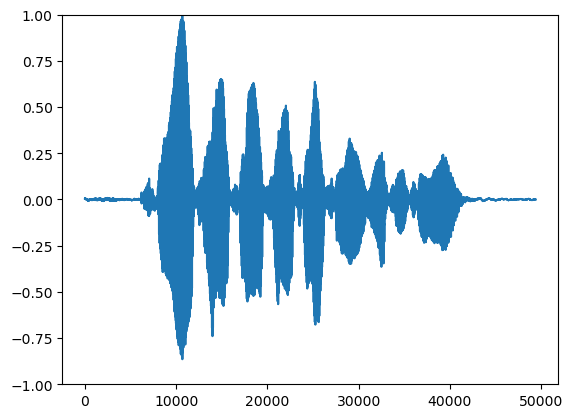

In [88]:
import matplotlib.pyplot as plt
#wav_file = '/Storage/speech/tts/kaist-audio-book/wav/남1_동화1/1181.wav'
#wav_file = '/Storage/speech/tts/kaist-audio-book/wav/여1_동화1/1181.wav'
wav_file = 'samples/good.wav'
wav, _ = librosa.load(wav_file, sr=16000, res_type='polyphase')
wav = wav / max(abs(wav))

plt.plot(wav)
plt.ylim([-1, 1])
plt.show()

In [89]:
def get_blendshape(wav, sid, layer=8):
    with torch.no_grad():
        wav = torch.Tensor(wav).unsqueeze(0).to(device)
        states = wav2vec(wav, output_hidden_states=True).hidden_states[layer].transpose(1, 2)
        states = F.interpolate(states, scale_factor=3/5, mode='linear').detach()
    sid = torch.Tensor([sid]).long().to(device)
    with torch.no_grad():
        y = model.inference(states, sid=sid, temperature=0.1)
        y = torch.clamp(y, min=0, max=1)
    y = y[0].data.cpu().numpy()
    print(wav.shape, y.shape)
    return y
    
ys = []
for sid in range(1, 8):
    y = get_blendshape(wav, sid)
    ys.append(y)
    
ys = np.stack(ys)
print(ys.shape)

np.save('samples/infer08.24-1.npy', ys)
print('done')

torch.Size([1, 49413]) (61, 92)
torch.Size([1, 49413]) (61, 92)
torch.Size([1, 49413]) (61, 92)
torch.Size([1, 49413]) (61, 92)
torch.Size([1, 49413]) (61, 92)
torch.Size([1, 49413]) (61, 92)
torch.Size([1, 49413]) (61, 92)
(7, 61, 92)
done


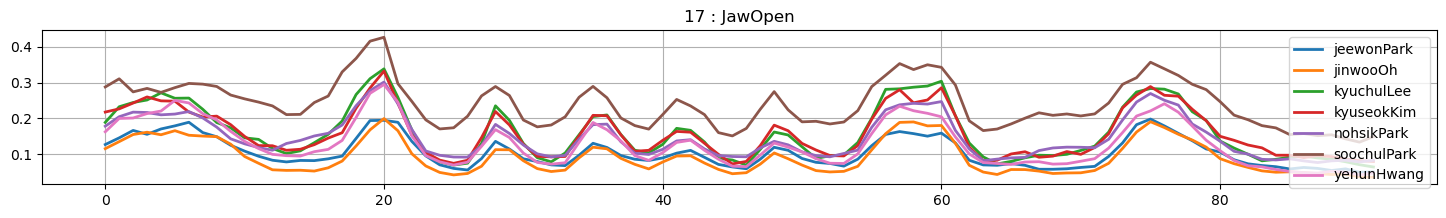

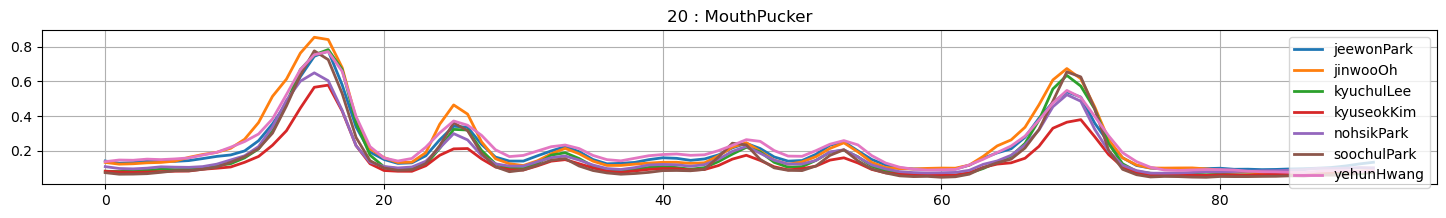

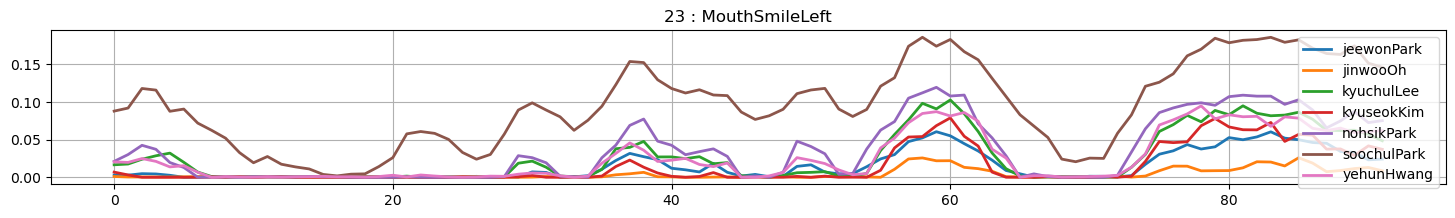

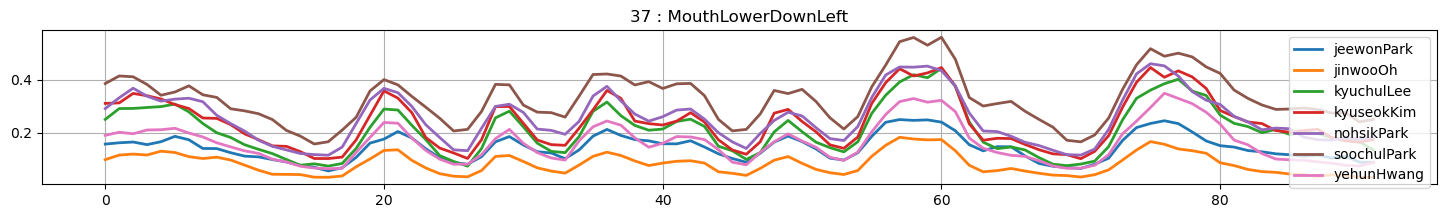

In [90]:
names = ['jeewonPark', 'jinwooOh', 'kyuchulLee', 'kyuseokKim', 'nohsikPark', 'soochulPark', 'yehunHwang']
targets = [(17, 'JawOpen'), (20, 'MouthPucker'), (23, 'MouthSmileLeft'), (37, 'MouthLowerDownLeft')]

for target in targets:
    plt.figure(figsize=[18, 2])
    plt.title(str(target[0]) + ' : ' + target[1])
    for i in range(len(ys)):
        plt.plot(ys[i][target[0]], label=names[i], linewidth=2)
    plt.grid()
    plt.legend()
    plt.show()

### Test

In [78]:
import os

root_dir = '/data/speech/digital_human/preprocessed/'

def get_files(dir):
    data = []
    files = sorted([os.path.join(dir, file) for file in os.listdir(dir)])
    for file in files:
        if file.endswith('.npy') and 'ARKit' in file:
            data.append(file)
        if os.path.isdir(file):
            data.extend(get_files(os.path.join(dir, file)))
    return data

files = get_files(root_dir)
print(len(files))

76


In [79]:
for i, file in enumerate(files):
    if '_10_' in file:
        print(i)

0
10
20
30
49


In [63]:
from librosa import resample
data = np.load(files[30], allow_pickle=True).item()
print(data.keys())

wav = resample(data['wav'], orig_sr=44100, target_sr=16000, res_type='polyphase')
gt = data['blendshapes']
gt = gt[1000:2000].T
wav = wav[int(1000*16000/30):int(2000*16000/30)]
print(wav.shape, gt.shape)

dict_keys(['wav', 'blendshapes'])
(533333,) (61, 1000)


In [64]:
pr = get_blendshape(wav, 1)
print(gt.shape, pr.shape)
print('done')

torch.Size([1, 533333]) (61, 999)
(61, 1000) (61, 999)
done


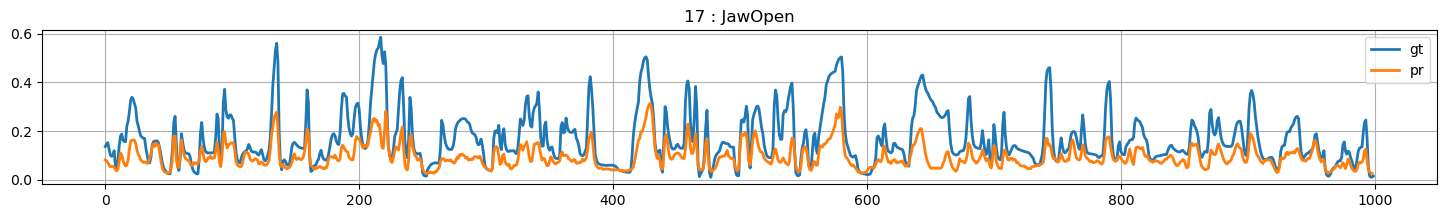

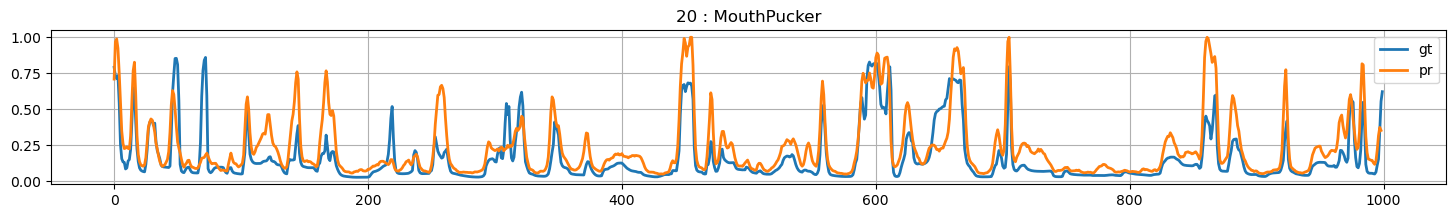

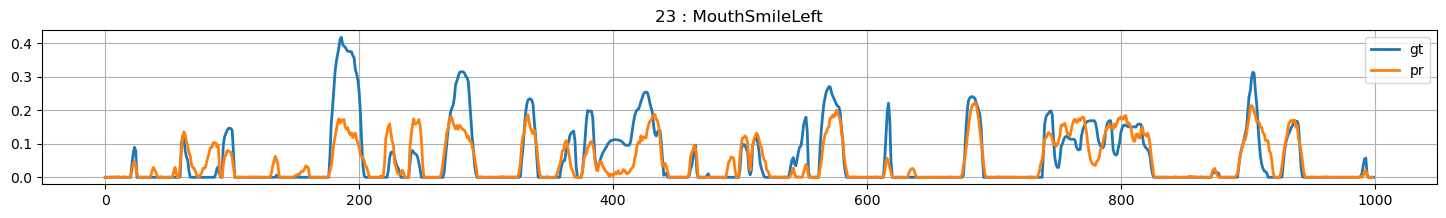

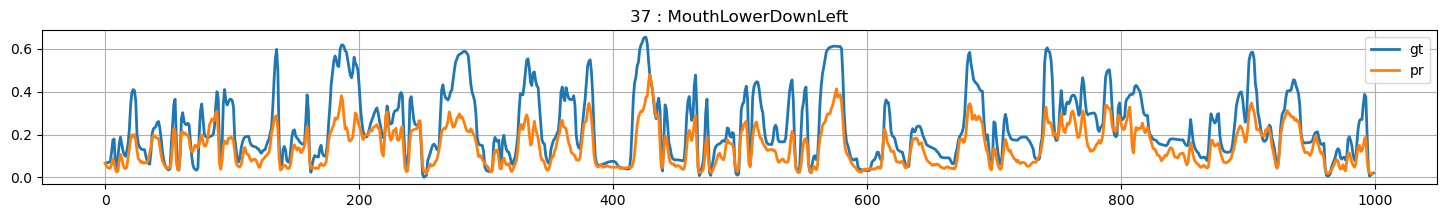

In [65]:
names = [(17, 'JawOpen'), (20, 'MouthPucker'), (23, 'MouthSmileLeft'), (37, 'MouthLowerDownLeft')]

for name in names:
    plt.figure(figsize=[18, 2])
    plt.title(str(name[0]) + ' : ' + name[1])    
    plt.plot(gt[name[0]], label='gt', linewidth=2)
    plt.plot(pr[name[0]], label='pr', linewidth=2)
    plt.grid()
    plt.legend()
    plt.show()
